In [1]:
import xgboost
import shap
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import train_test_split
from boostwrap import Regressor, Classifier
%load_ext autoreload
%autoreload 2

In [2]:
# graphical notebook options
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### STEPS to RUN THIS NOTEBOOK


**Clone bootswrap from github:**

$ git clone https://github.com/bbglab/boostwrap.git

Go to package folder:

$ git checkout develop

$ pip install -e .

**Install requirements in environment**

pip install -r requirements.txt

**launch notebook with:**

$ jupyter notebook --NotebookApp.iopub_data_rate_limit=10000000 testing.ipynb

In [3]:
def plotParam(fontsize=10):
    """
    plot parameters
    :return:
    """
    plt.rcParams['font.sans-serif'] = ['arial']
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['font.family'] = ['sans-serif']
    plt.rcParams['svg.fonttype'] = 'none'
    plt.rcParams['mathtext.fontset'] = 'custom'
    plt.rcParams['mathtext.cal'] = 'arial'
    plt.rcParams['mathtext.rm'] = 'arial'
plotParam(fontsize=14)

In [19]:
df = pd.read_csv('/workspace/projects/INCUBATOR/genomewide_NER/results/tests/ferrans_df.txt', sep='\t')

In [20]:
df.head()

CPDs_48h  TT_NHF1_CPD_10J_0h  lad_covered_bp_ENCODE   line_bp  \
0      2452           -3.779900              -1.101929 -2.465221   
1      7288           -2.367925              -1.101929 -0.844892   
2      7429           -1.927917              -1.101929 -0.850946   
3      2737           -2.493722              -1.101929 -2.007192   
4      4360           -1.755862              -1.101929 -0.334372   

   all_expected_decrease  E055_H3K9me3_covered_bp   TFBS_bp  cytoband_gpos_bp  \
0              -4.816212                -0.375474  3.089606         -1.273599   
1              -0.840292                 7.121662 -0.832497          0.955652   
2              -0.461637                 5.251256 -0.799552         -0.381899   
3              -2.799216                -0.587718  2.404156         -1.273599   
4              -1.198973                 0.401523  0.230614          0.509802   

   nucleosome_covered_bp  CT_TC_NHF1_CPD_10J_0h          ...            \
0               0.425896              -4.100433          ...             
1               1.654762              -1.818554          ...             
2               1.595508              -0.897889          ...             
3               1.495902              -2.517627          ...             
4               1.519057              -1.064084          ...             

   E055_H3K4me1_covered_bp  genic_bp  skin_CTCF_bp  E055_H3K27me3_covered_bp  \
0                 2.478874  0.713507      0.022434                  2.049688   
1                -1.055355 -1.104917     -0.824954                 -0.633871   
2                -0.993173 -1.302492      0.441905                 -0.679968   
3                 1.498447  1.336236      0.061848                  2.026497   
4                -0.256162  1.479058      0.061848                  1.132642   

     ltr_bp   sine_bp  E055_H3K4me3_covered_bp  E055_H3K36me3_covered_bp  \
0 -1.395978  1.500432                 6.090828                  3.846877   
1  2.569134 -0.758785                -0.789020                 -0.768791   
2  2.363850 -0.769853                -0.795401                 -0.450070   
3 -1.511009  1.524278                 2.248595                  1.996514   
4 -1.252263  0.117550                -0.245937                 -0.688839   

      n_TSS  E055_DNase_covered_bp  
0  4.859485               1.432580  
1 -0.601307              -1.260905  
2 -0.702433              -1.196466  
3  2.836969               1.076356  
4 -0.500181              -0.384988  

[5 rows x 21 columns]

In [5]:
covariates = list(df.columns)
covariates.remove('CPDs_48h')
x_data = df[covariates]
y_data = df[['CPDs_48h']]

In [31]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=0.5)

/home/fmuinos/anaconda3/envs/mmr_env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


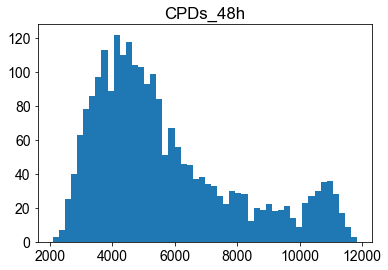

In [19]:
y_data.hist(bins=50)
plt.grid(False)
plt.show()

In [21]:
# Estimate some statistics
import patsy
from statsmodels.discrete.discrete_model import NegativeBinomial

covariates = list(df.columns)
covariates.remove('CPDs_48h')
x_data = df[covariates]
y_data = df[['CPDs_48h']]

# regression model fitting to infer overdispersion
y, x = patsy.dmatrices('CPDs_48h ~ 1', df)
model = NegativeBinomial(endog=y, exog=x)
res = model.fit()
a = res.params[-1]
mu = np.mean(y_data.values)
l = len(y_data)
a, mu, l

Optimization terminated successfully.
         Current function value: 9.055505
         Iterations: 6
         Function evaluations: 8
         Gradient evaluations: 8


(0.14567108293798228, 5707.70884993587, 2339)

In [22]:
# produce synthetic dataset with similar shape

# First part: a new response variable
# -----------------------------------

g = scipy.stats.gamma.rvs(1/a, scale=mu*a, size=l)
counts = scipy.stats.poisson.rvs(g)

# verify that the computations are done right

dg = pd.DataFrame({'y': counts, 'mu': g})
y, x = patsy.dmatrices('y ~ 1', dg)
model = NegativeBinomial(endog=y, exog=x,)
res = model.fit()
a = res.params[-1]
mu = np.mean(counts)
l = len(counts)
a, mu, l

Optimization terminated successfully.
         Current function value: 9.055151
         Iterations: 6
         Function evaluations: 8
         Gradient evaluations: 8


(0.14671762810237307, 5687.1769987174, 2339)

In [23]:
# Second part: synthetic covariates with known linear effect
# ------------------------------------------------------

covariates = np.empty((l, 10))
for i in range(10):
    covariates[:, i] = np.exp(np.random.normal(size=l))
weights = np.array(range(10))
means = covariates.dot(weights)
lambdas = means / g
covariates = np.dot(np.diag(1 / lambdas), covariates)

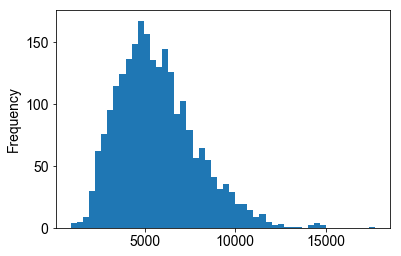

f_0         f_1         f_2         f_3         f_4         f_5  \
0  141.793641   27.988171   20.902729  360.231553  309.933376   80.828858   
1   19.418984  201.864344  127.136989   23.876887  256.640291   76.722038   
2   68.229095   50.350930   67.657215   20.101028   21.219729  123.049270   
3  198.849191   59.129051  171.650564   87.996484  251.762261  141.591111   
4   82.164523   32.295084   60.468015   36.009013   41.682046   24.314665   

          f_6         f_7         f_8         f_9  counts  
0   45.360122   95.242533   31.885691  108.719624    4987  
1   27.301780  252.647902   31.445102   62.983865    4703  
2   89.782376   86.537152  130.646269   18.285164    3287  
3  179.950108  166.985610  184.801656    8.057571    6138  
4   51.584879  327.936807   29.152196  121.938359    4537

In [24]:
# define expected number of mutations at random for 1000 samples
dg = pd.DataFrame({})
for i in range(10):
    dg['f_{}'.format(i)] = covariates[:, i]
dg['counts'] = counts
dg['counts'].plot.hist(bins=50)
plt.show()
dg.head()

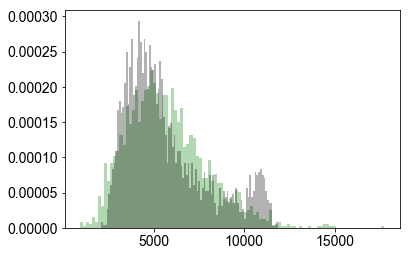

In [25]:
plt.hist(dg['counts'], bins=100, normed=True, alpha=0.3, color='green')
plt.hist(df['CPDs_48h'], bins=100, normed=True, alpha=0.3, color='black')
plt.show()

In [15]:
params= {'objective': 'reg:linear',
         'colsample_bytree': 0.5,
         'gamma': 0.2,
         'learning_rate': 0.001,
         'max_delta_step': 0,
         'max_depth': 4,
         'min_child_weight': 1,
         'scale_pos_weight': 1,
         'seed': 42,
         'silent': True,
         'subsample': 0.5,
         'nthread': 4}

params['n_estimators'] = 15000

In [27]:
covariates = list(dg.columns)
covariates.remove('counts')
x_synth = dg[covariates]
y_synth = dg[['counts']]
myregressor = Regressor(**params)
myregressor.train(x_synth, y_synth)

In [28]:
# load JS visualization code to notebook
shap.initjs() 

# train XGBoost model
# model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(x_data, label=y_data), 100)

# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
shap_values = shap.TreeExplainer(myregressor.model).shap_values(x_synth)

## Matrix of SHAP-values: 

**rows:** samples

**columns:** covariates

Last column represents the average prediction, namely, SHAP value $\phi_0$ upon which we add/subtract the effects represented by the features. 

In [29]:
# visualize the first prediction's explanation
shap.force_plot(shap_values[0,:], x_synth.iloc[0,:])

In [30]:
# visualize the additive explanation of the response prediction per sample
shap.force_plot(shap_values, x_synth)

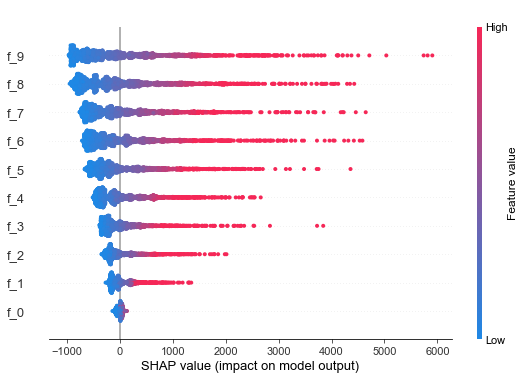

In [31]:
# summarize the effects of all the features
# plot_type="violin", "dot", "bar"
feature_order, feature_names, features, shap_values = shap.summary_plot(shap_values, x_synth, plot_type="dot")

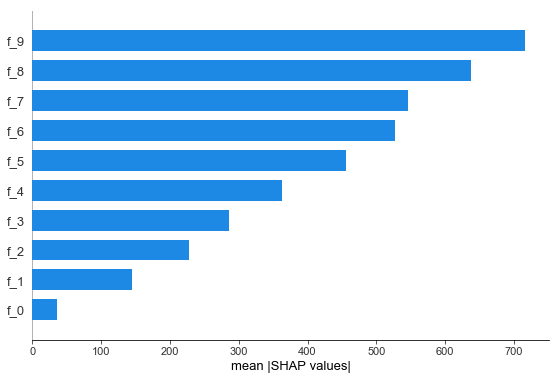

In [32]:
feature_order, feature_names, features, shap_values = shap.summary_plot(shap_values, x_synth, plot_type="bar")

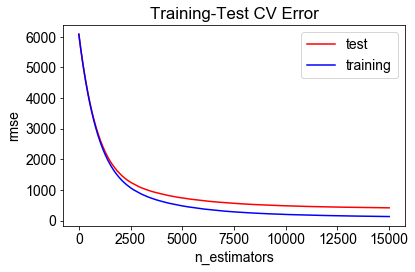

In [33]:
CV = myregressor.cv(fold=2, method='rmse')
fig, ax = plt.subplots()
CV.plot(ax)
plt.show()

In [34]:
CV.tail()

test-rmse-mean  test-rmse-std  train-rmse-mean  train-rmse-std
14995      417.089325      18.699493       132.647995        1.575790
14996      417.081848      18.694153       132.639611        1.574776
14997      417.077942      18.691803       132.630936        1.573990
14998      417.072968      18.689972       132.622123        1.574485
14999      417.063278      18.689285       132.614769        1.573875

In [35]:
feature_names

Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9'], dtype='object')

In [7]:
def concordance(shap_values, y, response):
    variance_explained = []
    predicted = shap_values[:, -1].copy()
    sort_index = np.argsort(list(y[response].values))
    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))
    for i, ind in enumerate(feature_order[::-1]):
        predicted += shap_values[:, ind]
        if i == 0:
            ax[0].scatter(y.values, predicted, color='red', alpha=0.2)
            ax[1].plot(range(len(predicted)), [predicted[j] for j in sort_index], alpha=0.1, color='red')
        if i == len(feature_order) - 1:
            ax[0].scatter(y.values, predicted, color='green', alpha=0.2)
            ax[1].plot(range(len(sort_index)), [predicted[j] for j in sort_index], alpha=0.1, color='green')
        variance_explained.append(explained_variance_score(y.values, predicted))
    ax[1].plot(range(len(sort_index)), 
               [y[response].values[j] for j in sort_index], 
               alpha=0.5, color='black', linestyle='--')
    ax[0].set_title('Concordance')
    ax[0].set_xlabel('observed_response')
    ax[0].set_ylabel('predicted_response')
    
    ax[1].set_title('Predictions')
    ax[1].set_xlabel('samples')
    ax[1].set_ylabel('response')
    plt.show()
    return variance_explained
    
variance_explained = concordance(shap_values, y_synth, 'counts')

NameError: name 'shap_values' is not defined

In [37]:
variance_explained = list(map(lambda a: np.round(a, 3), variance_explained))

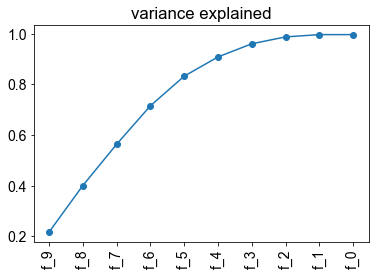

In [38]:
plt.plot(range(len(feature_names)), variance_explained, '-o')

plt.xticks(range(len(feature_names)), 
           [feature_names[ind] for ind in feature_order[::-1]],
           rotation = 90)
plt.title('variance explained')
plt.show()

In [57]:
params['n_estimators'] = 2500
myregressor = Regressor(**params)
myregressor.train(x_train, y_train)

In [58]:
# load JS visualization code to notebook
shap.initjs() 

# train XGBoost model
# model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(x_data, label=y_data), 100)

# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
shap_values = shap.TreeExplainer(myregressor.model).shap_values(x_train)

In [59]:
# visualize the first prediction's explanation
shap.force_plot(shap_values[0,:], x_train.iloc[0,:])

In [60]:
# visualize the additive explanation of the response prediction per sample
shap.force_plot(shap_values, x_train)

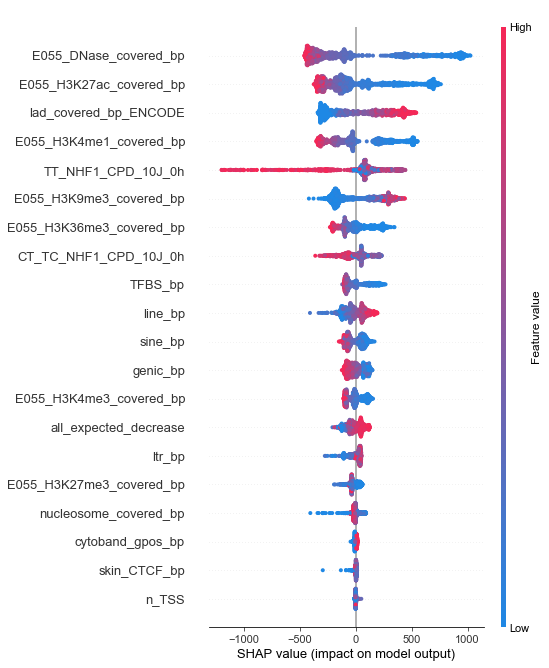

In [61]:
# summarize the effects of all the features
# plot_type="violin", "dot", "bar"
feature_order, feature_names, features, shap_values = shap.summary_plot(shap_values, x_train, plot_type="dot")

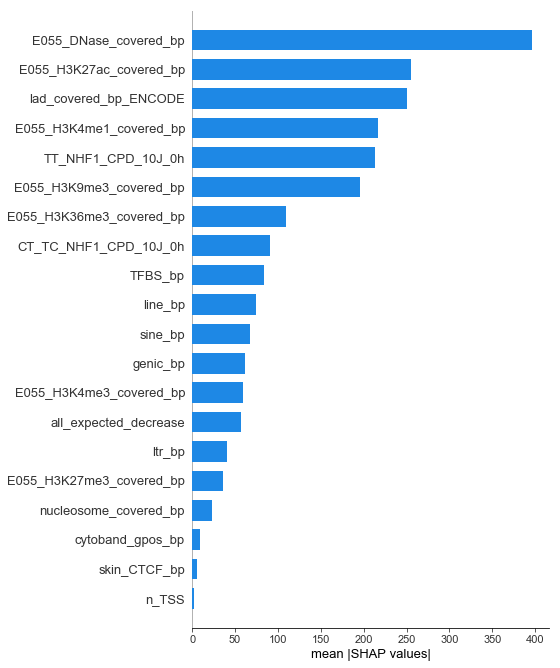

In [62]:
feature_order, feature_names, features, shap_values = shap.summary_plot(shap_values, x_train, plot_type="bar")

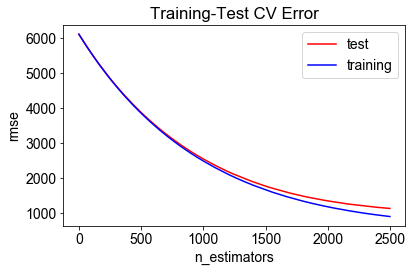

In [63]:
CV = myregressor.cv(fold=2, method='rmse')
fig, ax = plt.subplots()
CV.plot(ax)
plt.show()

In [13]:
feature_names

Index(['TT_NHF1_CPD_10J_0h', 'lad_covered_bp_ENCODE', 'line_bp',
       'all_expected_decrease', 'E055_H3K9me3_covered_bp', 'TFBS_bp',
       'cytoband_gpos_bp', 'nucleosome_covered_bp', 'CT_TC_NHF1_CPD_10J_0h',
       'E055_H3K27ac_covered_bp', 'E055_H3K4me1_covered_bp', 'genic_bp',
       'skin_CTCF_bp', 'E055_H3K27me3_covered_bp', 'ltr_bp', 'sine_bp',
       'E055_H3K4me3_covered_bp', 'E055_H3K36me3_covered_bp', 'n_TSS',
       'E055_DNase_covered_bp'],
      dtype='object')

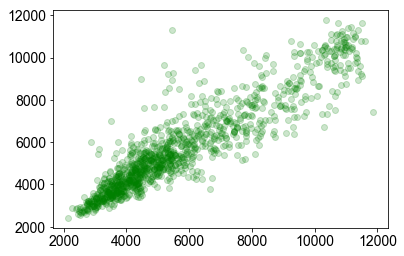

In [55]:
plt.scatter(y_test.values, myregressor.predict(x_test), alpha=0.2, color='green')
plt.show()

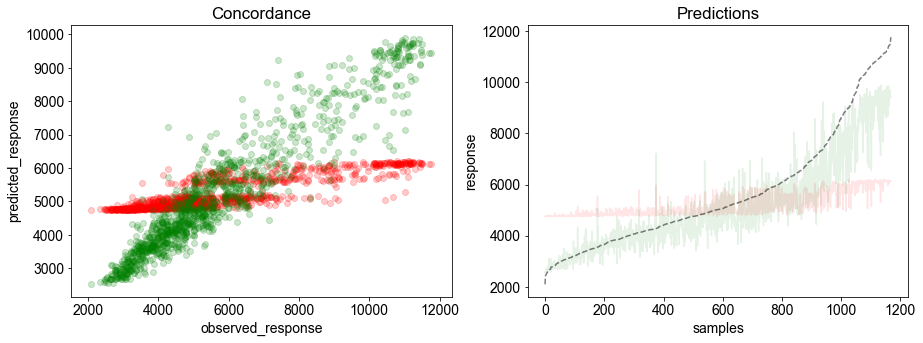

In [64]:
def concordance(shap_values, y, response):
    variance_explained = []
    predicted = shap_values[:, -1].copy()
    sort_index = np.argsort(list(y[response].values))
    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))
    for i, ind in enumerate(feature_order[::-1]):
        predicted += shap_values[:, ind]
        if i == 0:
            ax[0].scatter(y.values, predicted, color='red', alpha=0.2)
            ax[1].plot(range(len(predicted)), [predicted[j] for j in sort_index], alpha=0.1, color='red')
        if i == len(feature_order) - 1:
            ax[0].scatter(y.values, predicted, color='green', alpha=0.2)
            ax[1].plot(range(len(sort_index)), [predicted[j] for j in sort_index], alpha=0.1, color='green')
        variance_explained.append(explained_variance_score(y.values, predicted))
    ax[1].plot(range(len(sort_index)), 
               [y[response].values[j] for j in sort_index], 
               alpha=0.5, color='black', linestyle='--')
    ax[0].set_title('Concordance')
    ax[0].set_xlabel('observed_response')
    ax[0].set_ylabel('predicted_response')
    
    ax[1].set_title('Predictions')
    ax[1].set_xlabel('samples')
    ax[1].set_ylabel('response')
    plt.show()
    return variance_explained
    
variance_explained = concordance(shap_values, y_train, 'CPDs_48h')

In [65]:
variance_explained = list(map(lambda a: np.round(a, 3), variance_explained))

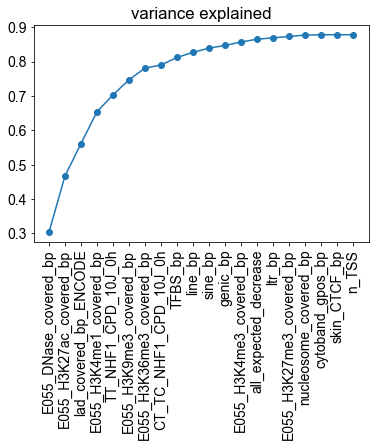

In [66]:
plt.plot(range(len(feature_names)), variance_explained, '-o')

plt.xticks(range(len(feature_names)), 
           [feature_names[ind] for ind in feature_order[::-1]],
           rotation = 90)
plt.title('variance explained')
plt.show()

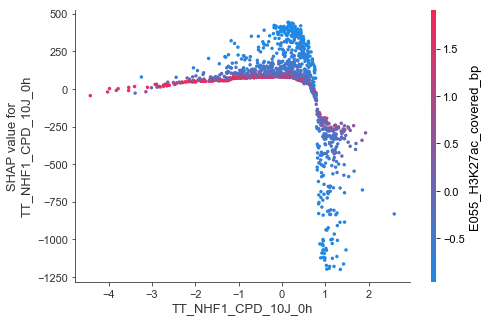

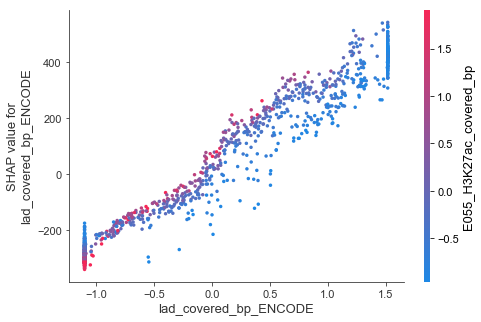

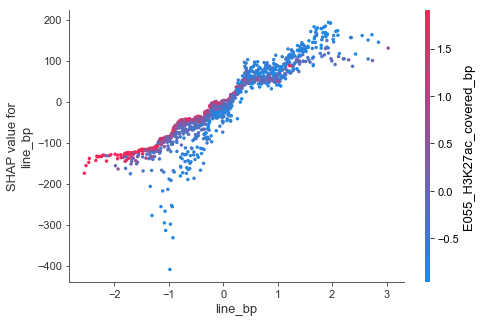

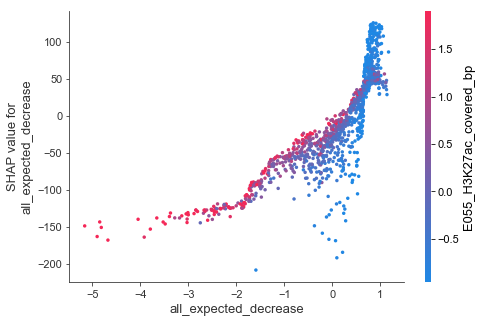

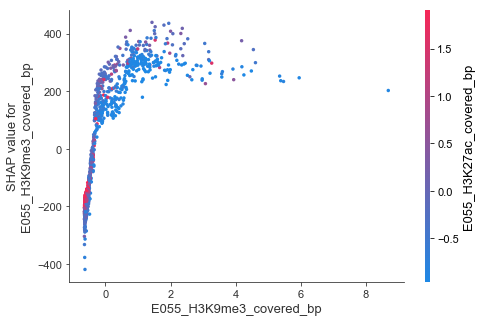

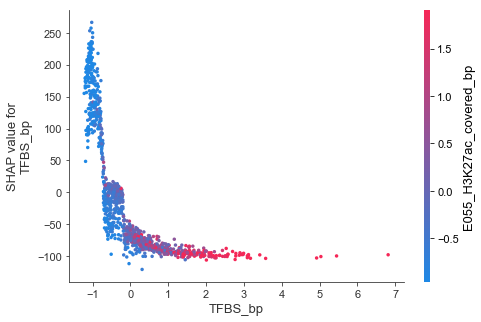

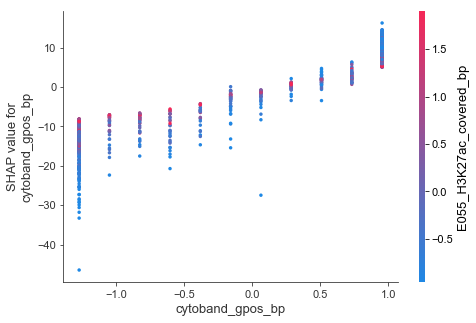

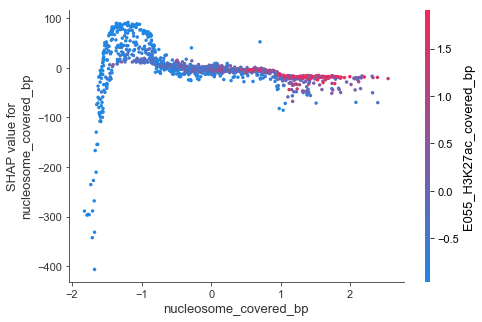

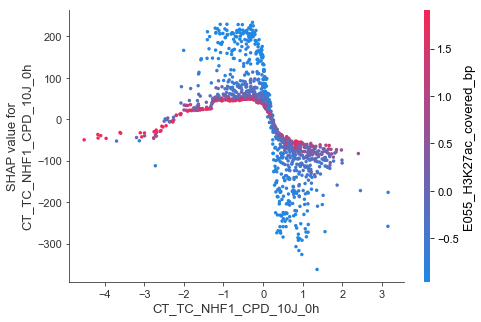

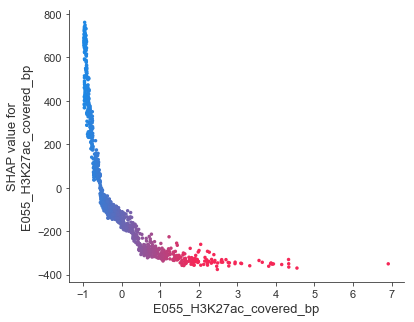

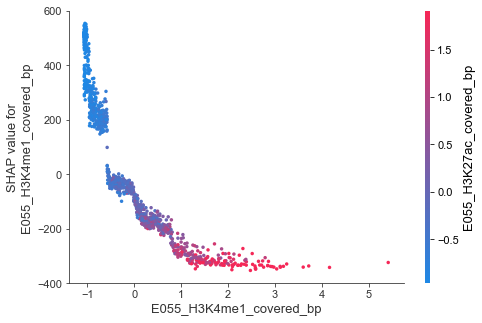

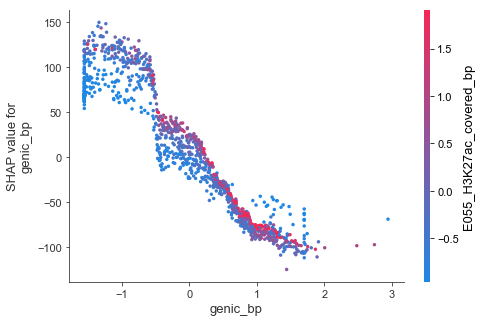

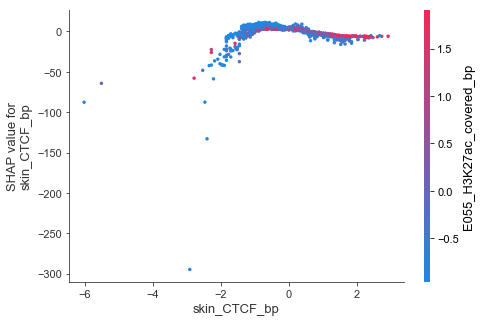

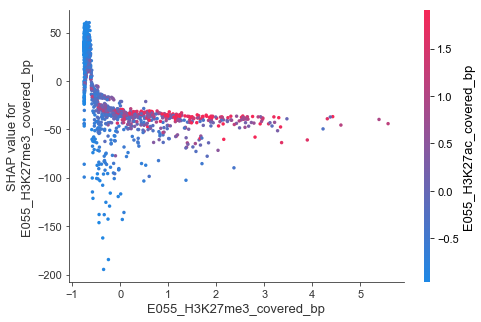

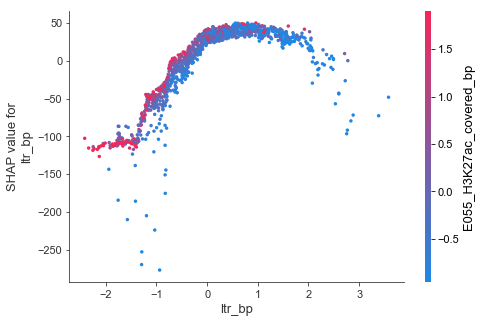

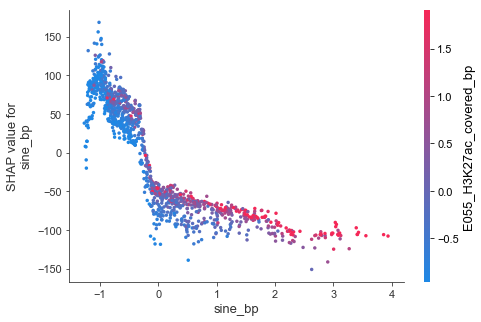

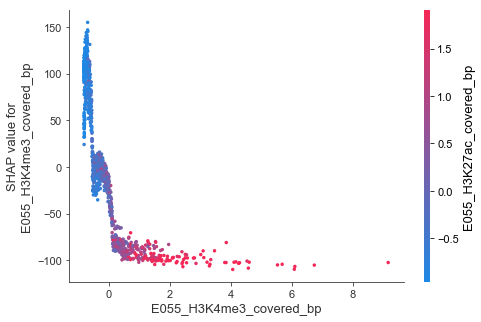

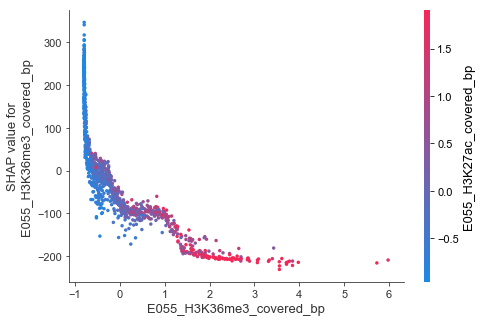

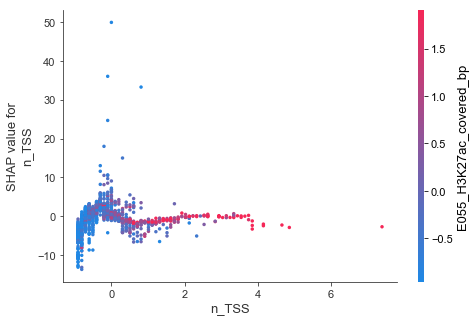

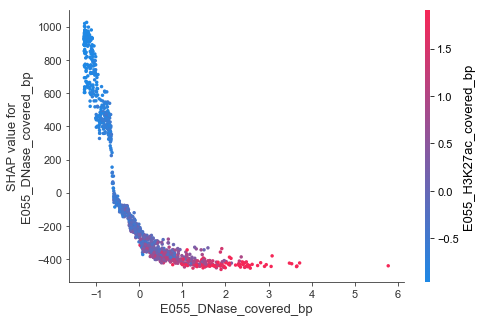

In [69]:
# create a SHAP dependence plots to show the effect of a single feature across the whole dataset
feature_to_interact = 'E055_H3K27ac_covered_bp'
for col in covariates:
    shap.dependence_plot(col, shap_values, x_train, 
                         interaction_index=covariates.index(feature_to_interact), 
                         dot_size=12)

# Negative Binomial Regression

In [113]:
import patsy
from statsmodels.discrete.discrete_model import NegativeBinomial

covariates = list(df.columns)
covariates.remove('CPDs_48h')
x_data = df[covariates]
y_data = df[['CPDs_48h']]

# regression model fitting to infer overdispersion
y, x = patsy.dmatrices('CPDs_48h ~ 1 + {0}'.format('+'.join(covariates)), df)
model = NegativeBinomial(endog=y, exog=x)
res = model.fit_regularized()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 8.220426110050331
            Iterations: 28
            Function evaluations: 63
            Gradient evaluations: 28


/home/fmuinos/anaconda3/envs/mmr_env/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:984: RuntimeWarning: overflow encountered in exp
  return np.sum(-np.exp(XB) +  endog*XB - gammaln(endog+1))
/home/fmuinos/anaconda3/envs/mmr_env/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:2468: RuntimeWarning: invalid value encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/fmuinos/anaconda3/envs/mmr_env/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:2468: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)


In [114]:
res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: NegativeBinomial
==========================================================================
Model:                 NegativeBinomial    Pseudo R-squared:    0.092     
Dependent Variable:    CPDs_48h            AIC:                 38499.1533
Date:                  2018-06-20 20:15    BIC:                 38625.8179
No. Observations:      2339                Log-Likelihood:      -19228.   
Df Model:              20                  LL-Null:             -21181.   
Df Residuals:          2318                LLR p-value:         0.0000    
Converged:             1.0000              Scale:               1.0000    
No. Iterations:        28.0000                                            
--------------------------------------------------------------------------
                          Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------------
Intercept                 8.5892   0.0035 2457.8800 0.0000  8.5824  8.5961
TT_NHF1_CPD_10J_0h       -0.2110   0.0174  -12.0975 0.0000 -0.2452 -0.1768
lad_covered_bp_ENCODE     0.0666   0.0045   14.9115 0.0000  0.0579  0.0754
line_bp                   0.0773   0.0058   13.3060 0.0000  0.0659  0.0887
all_expected_decrease     0.2962   0.0152   19.4740 0.0000  0.2664  0.3260
E055_H3K9me3_covered_bp   0.0636   0.0054   11.7272 0.0000  0.0530  0.0742
TFBS_bp                  -0.0137   0.0104   -1.3161 0.1881 -0.0340  0.0067
cytoband_gpos_bp          0.0140   0.0039    3.5792 0.0003  0.0063  0.0217
nucleosome_covered_bp    -0.0873   0.0113   -7.7125 0.0000 -0.1094 -0.0651
CT_TC_NHF1_CPD_10J_0h    -0.0160   0.0119   -1.3377 0.1810 -0.0394  0.0074
E055_H3K27ac_covered_bp   0.0203   0.0187    1.0854 0.2778 -0.0164  0.0570
E055_H3K4me1_covered_bp  -0.0261   0.0157   -1.6597 0.0970 -0.0568  0.0047
genic_bp                 -0.0278   0.0043   -6.4496 0.0000 -0.0362 -0.0193
skin_CTCF_bp             -0.0036   0.0041   -0.8829 0.3773 -0.0117  0.0044
E055_H3K27me3_covered_bp -0.0042   0.0069   -0.6059 0.5446 -0.0178  0.0094
ltr_bp                    0.0157   0.0049    3.2380 0.0012  0.0062  0.0252
sine_bp                   0.1251   0.0104   12.0381 0.0000  0.1047  0.1454
E055_H3K4me3_covered_bp   0.0750   0.0135    5.5438 0.0000  0.0485  0.1015
E055_H3K36me3_covered_bp -0.0484   0.0090   -5.3444 0.0000 -0.0661 -0.0306
n_TSS                    -0.0028   0.0068   -0.4069 0.6841 -0.0160  0.0105
E055_DNase_covered_bp    -0.0942   0.0118   -7.9833 0.0000 -0.1174 -0.0711
alpha                     0.0284   0.0008   34.1454 0.0000  0.0267  0.0300
==========================================================================

"""

In [143]:
def stepwise_selection(df):
    n = len(covariates)
    selected = []
    score = 0
    while len(selected) < n: 
        candidate = None
        for cov in covariates:
            y, x = patsy.dmatrices('CPDs_48h ~ {0} + 1'.format(' + '.join(selected + [cov])), df)
            model = NegativeBinomial(endog=y, exog=x)
            res = model.fit_regularized(alpha=0.5)
            if res.bic > score:
                score = res.bic
                candidate = cov
        if candidate is None:
            return selected
        else:
            selected.append(candidate)
            covariates.remove(candidate)
    return selected

In [144]:
covariates = list(df.columns)
covariates.remove('CPDs_48h')
stepwise_selection(df)

/home/fmuinos/anaconda3/envs/mmr_env/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:984: RuntimeWarning: overflow encountered in exp
  return np.sum(-np.exp(XB) +  endog*XB - gammaln(endog+1))
/home/fmuinos/anaconda3/envs/mmr_env/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:2468: RuntimeWarning: invalid value encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/fmuinos/anaconda3/envs/mmr_env/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:788: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred) # not cdf
/home/fmuinos/anaconda3/envs/mmr_env/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:2468: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)


QC check did not pass for 1 out of 2 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
Could not trim params automatically due to failed QC check.  Trimming using trim_mode == 'size' will still work.
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 9.019859620202704
            Iterations: 20
            Function evaluations: 24
            Gradient evaluations: 20
QC check did not pass for 1 out of 2 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
Could not trim params automatically due to failed QC check.  Trimming using trim_mode == 'size' will still work.
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 8.809361395269562
            Iterations: 15
            Function evaluations: 19
            Gradient evaluations: 15
QC check did not pass for 1 out of 2 parameters
Try increasing solver accu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 8.912530227610217
            Iterations: 67
            Function evaluations: 88
            Gradient evaluations: 67
QC check did not pass for 2 out of 2 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
Could not trim params automatically due to failed QC check.  Trimming using trim_mode == 'size' will still work.
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 8.57583511759721
            Iterations: 20
            Function evaluations: 26
            Gradient evaluations: 20
QC check did not pass for 2 out of 3 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
Could not trim params automatically due to failed QC check.  Trimming using trim_mode == 'size' will still work.
Optimization terminated successfully.    (Exit mode 0)
            Current 

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 8.73938319250373
            Iterations: 26
            Function evaluations: 33
            Gradient evaluations: 26
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 8.717959988569968
            Iterations: 77
            Function evaluations: 106
            Gradient evaluations: 77
QC check did not pass for 2 out of 3 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
Could not trim params automatically due to failed QC check.  Trimming using trim_mode == 'size' will still work.
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 8.773912333944919
            Iterations: 19
            Function evaluations: 27
            Gradient evaluations: 19
QC check did not pass for 1 out of 3 parameters
Try increasing solver accuracy or number of iterations, decreasing al

/home/fmuinos/anaconda3/envs/mmr_env/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 8.532728549952768
            Iterations: 103
            Function evaluations: 134
            Gradient evaluations: 103
QC check did not pass for 2 out of 5 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
Could not trim params automatically due to failed QC check.  Trimming using trim_mode == 'size' will still work.
QC check did not pass for 1 out of 4 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
Could not trim params automatically due to failed QC check.  Trimming using trim_mode == 'size' will still work.
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 8.537129961118147
            Iterations: 30
            Function evaluations: 39
            Gradient evaluations: 30
QC check did not pass for 1 out of 4 parameters
Try increasing solver a

['sine_bp', 'E055_DNase_covered_bp']

In [55]:
params = list(res.params)
params.pop(0)
params.pop()
argsort = np.argsort(params)
mydict = {covariates[i]: [abs(params[i])] for i in argsort}

In [56]:
mydict

{'CT_TC_NHF1_CPD_10J_0h': [0.015982764100512484],
 'E055_DNase_covered_bp': [0.09424288699039876],
 'E055_H3K27ac_covered_bp': [0.020302035278541592],
 'E055_H3K27me3_covered_bp': [0.004198146672766929],
 'E055_H3K36me3_covered_bp': [0.04835659955518178],
 'E055_H3K4me1_covered_bp': [0.02605980045206612],
 'E055_H3K4me3_covered_bp': [0.074957595758123],
 'E055_H3K9me3_covered_bp': [0.06360036743273458],
 'TFBS_bp': [0.013659961458670709],
 'TT_NHF1_CPD_10J_0h': [0.21098276913889982],
 'all_expected_decrease': [0.29621412358517274],
 'cytoband_gpos_bp': [0.014033412095147833],
 'genic_bp': [0.027787060437739635],
 'lad_covered_bp_ENCODE': [0.06660964291320023],
 'line_bp': [0.07728434612043629],
 'ltr_bp': [0.015709986520872972],
 'n_TSS': [0.002757798248973264],
 'nucleosome_covered_bp': [0.08725929780515847],
 'sine_bp': [0.1250681931246497],
 'skin_CTCF_bp': [0.0036471100464186327]}

# Using boostwrap for logistic regression

In [7]:
# This is a hack to make graphviz work with the conda environment. Maybe you do not need it.
import os, sys
os.environ["PATH"] = os.path.dirname(sys.executable) + os.pathsep + os.environ["PATH"]

In [8]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn import model_selection, datasets
import shap

In [9]:
%matplotlib notebook

In [10]:
# Silencing some warning from scikit learn an numpy
import warnings
warnings.filterwarnings(module='sklearn*', action='ignore', category=DeprecationWarning)

In [11]:
from boostwrap import Regressor, Classifier

## Data preparation: Iris Dataset

In [12]:
from sklearn.datasets import load_iris
iris = load_iris()
covariates = iris.data
target = iris.target
column_names = iris.feature_names
df = pd.DataFrame(covariates, columns=iris.feature_names)
dg = pd.DataFrame(target, columns=['species'])
dg['species'] = dg['species'].apply(lambda x: 1 * (x == 0))
data = pd.concat([df, dg], axis=1)

## Regression

In [36]:
import pickle

params = {'booster': 'gbtree',
          'silent': True,
          'eta': 0.01,
          'gamma': 0,
          'max_depth': 5,
          'min_child_weight': 1,
          'objective': 'reg:linear',
          'nthread': 4,
          'seed': 42}

In [14]:
myclassifier = Classifier(**params)
x_data = data[iris.feature_names]
y_data = data['species']
x_train, x_test, y_train, y_test = model_selection.train_test_split(x_data, y_data, test_size=0.3, random_state=42)
myclassifier.train(x_train, y_train)

In [16]:
# load JS visualization code to notebook
shap.initjs() 

# train XGBoost model
# model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(x_data, label=y_data), 100)

# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
shap_values = shap.TreeExplainer(myclassifier.model).shap_values(x_train)

In [17]:
# visualize the first prediction's explanation
shap.force_plot(shap_values[0,:], x_train.iloc[0,:])

In [18]:
# visualize the additive explanation of the response prediction per sample
shap.force_plot(shap_values, x_train)

<IPython.core.display.Javascript object>


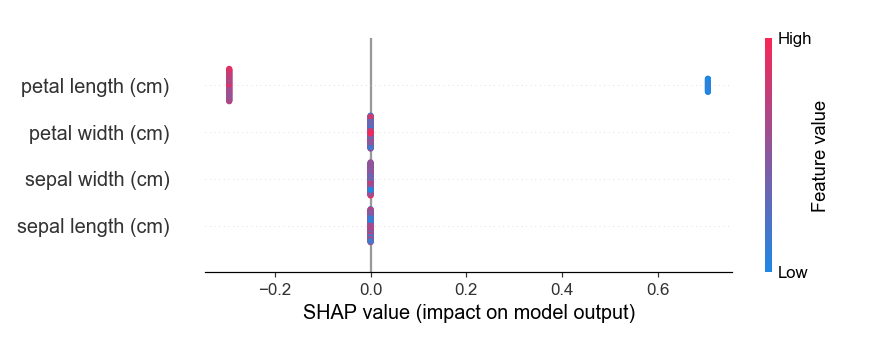

In [19]:
# summarize the effects of all the features
# plot_type="violin", "dot", "bar"
feature_order, feature_names, features, shap_values = shap.summary_plot(shap_values, x_train, plot_type="dot")

<IPython.core.display.Javascript object>


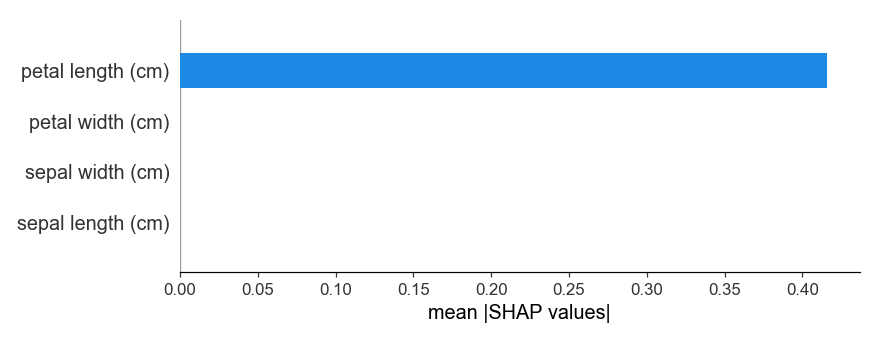

In [20]:
feature_order, feature_names, features, shap_values = shap.summary_plot(shap_values, x_train, plot_type="bar")

# Analysis with synthetic count data

<IPython.core.display.Javascript object>


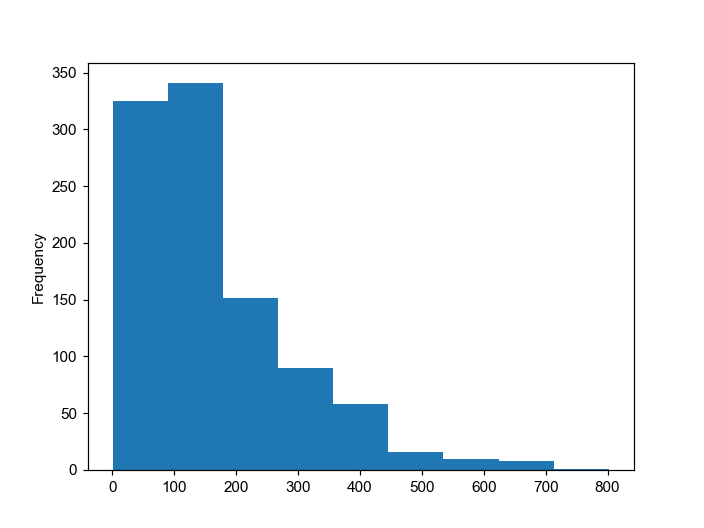

f_0       f_1       f_2       f_3       f_4       f_5       f_6  \
0  1.259374  0.769030  0.531905  1.307518  1.187394  1.149301  1.191001   
1  0.732524  0.945655  0.505102  0.584436  0.728672  0.543530  0.581102   
2  0.550887  0.928995  0.710630  0.694242  1.315039  0.623157  1.064808   
3  1.284636  1.207506  1.120536  0.550010  1.096158  1.156731  1.192064   
4  0.546016  1.210050  1.280957  0.683336  0.890375  0.779903  0.843458   

        f_7       f_8       f_9   ...        f_13      f_14      f_15  \
0  1.236719  1.137316  0.542572   ...    0.826927  0.765164  1.310681   
1  0.540897  1.099932  0.615753   ...    0.589361  0.718873  1.278852   
2  0.593056  0.507989  1.098902   ...    1.345516  0.593449  0.740214   
3  0.623506  0.776428  1.285357   ...    0.501399  0.518425  0.883152   
4  0.721410  1.263509  1.117826   ...    0.580276  1.076887  0.522106   

       f_16      f_17      f_18      f_19          mu    offset  counts  
0  1.337396  0.857315  1.207790  1.102708  191.785794  5.256379     101  
1  0.983976  0.982526  1.051685  0.666424  160.779605  5.080035     116  
2  0.857088  0.556443  0.824139  0.573246  147.403471  4.993174     183  
3  0.945183  0.828174  0.885996  1.305724  168.817513  5.128818     236  
4  1.160667  0.714711  0.698390  1.251846  168.987960  5.129827     614  

[5 rows x 23 columns]

In [24]:
# for the sake of demonstration of the method, we will produce a synthetic dataset
# -- set an overdispersion parameter
# -- produce a collection of expected number of mutations at random
# -- for each sample, draw a binomial die (produce a random variate) of the negative 
# with parameters: mean (mu) and overdispersion (a)

# define overdispersion parameter
a = 0.6

from scipy.stats import nbinom

def nbinom_rvs(mu, a):
    """random variate of nbinomial with mean=mu and overdispersion=a"""
    
    size = 1 / a
    prob = size / (size + mu)
    return nbinom.rvs(size, prob)

def nbinom_pvalue(mu, a, v):
    """p-value given mean=mu and overdispersion=a and random variate=v"""
    size = 1 / a
    prob = size / (size + mu)
    return 1 - nbinom.cdf(v, size, prob)

# produce the data frame with mu, offset, random variate of counts

# define expected number of mutations at random for 1000 samples
df = pd.DataFrame({})
for i in range(20):
    df['f_{}'.format(i)] = 0.5 * np.exp(np.random.random(size=1000))
df['mu'] = df.apply(lambda row: np.dot(row, np.array(range(20))), axis=1)
df['offset'] = df['mu'].map(lambda x: np.log(x))
df['counts'] = df['mu'].map(lambda x: nbinom_rvs(x, a))
df['counts'].plot.hist(bins=9)
plt.show()
df.head()

## Negative Binomial Regression

In [26]:
import patsy
# regression model fitting to infer overdispersion
y, x = patsy.dmatrices('counts ~ {}'.format(' + '.join(list(covariates))), df)
model = NegativeBinomial(endog=y, exog=x)
res = model.fit()

In [255]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     NegativeBinomial Regression Results                      
==============================================================================
Dep. Variable:                 counts   No. Observations:                 1000
Model:               NegativeBinomial   Df Residuals:                      979
Method:                           MLE   Df Model:                           20
Date:                Thu, 21 Jun 2018   Pseudo R-squ.:                0.001889
Time:                        10:29:25   Log-Likelihood:                -6031.2
converged:                       True   LL-Null:                       -6042.6
                                        LLR p-value:                    0.2972
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.9508      0.404      9.785      0.000       3.160       4.742
f_0            0.0268      0.103      0.261      0.794      -0.174       0.228
f_1            0.0375      0.101      0.370      0.712      -0.161       0.236
f_2           -0.0735      0.100     -0.736      0.462      -0.269       0.122
f_3            0.0422      0.102      0.414      0.679      -0.158       0.242
f_4            0.0898      0.102      0.881      0.378      -0.110       0.290
f_5           -0.0090      0.103     -0.087      0.930      -0.211       0.193
f_6           -0.1203      0.102     -1.176      0.240      -0.321       0.080
f_7            0.1644      0.102      1.618      0.106      -0.035       0.364
f_8           -0.0036      0.104     -0.035      0.972      -0.207       0.200
f_9           -0.0121      0.102     -0.118      0.906      -0.213       0.189
f_10           0.0716      0.101      0.706      0.480      -0.127       0.270
f_11           0.1501      0.105      1.432      0.152      -0.055       0.356
f_12           0.0144      0.103      0.140      0.889      -0.188       0.216
f_13           0.1188      0.104      1.141      0.254      -0.085       0.323
f_14          -0.0215      0.099     -0.217      0.828      -0.216       0.173
f_15           0.2004      0.100      1.999      0.046       0.004       0.397
f_16           0.1538      0.104      1.484      0.138      -0.049       0.357
f_17           0.2402      0.099      2.419      0.016       0.046       0.435
f_18           0.1441      0.103      1.405      0.160      -0.057       0.345
f_19           0.1116      0.101      1.100      0.271      -0.087       0.310
alpha          0.6065      0.025     23.824      0.000       0.557       0.656
==============================================================================
"""

In [37]:
covariates = list(df.columns)
covariates.remove('counts')
covariates.remove('mu')
x_data = df[covariates]
y_data = df[['counts']]
covariates

['f_0',
 'f_1',
 'f_2',
 'f_3',
 'f_4',
 'f_5',
 'f_6',
 'f_7',
 'f_8',
 'f_9',
 'f_10',
 'f_11',
 'f_12',
 'f_13',
 'f_14',
 'f_15',
 'f_16',
 'f_17',
 'f_18',
 'f_19',
 'offset']

### Gradient Boosting

In [69]:
params= {'objective': 'count:poisson',
         'colsample_bytree': 0.5,
         'gamma': 0.2,
         'learning_rate': 0.001,
         'max_delta_step': 0,
         'max_depth': 3,
         'min_child_weight': 1,
         'scale_pos_weight': 1,
         'seed': 42,
         'silent': True,
         'subsample': 0.5,
         'nthread': 4}

params['n_estimators'] = 2000

a=1.

<IPython.core.display.Javascript object>


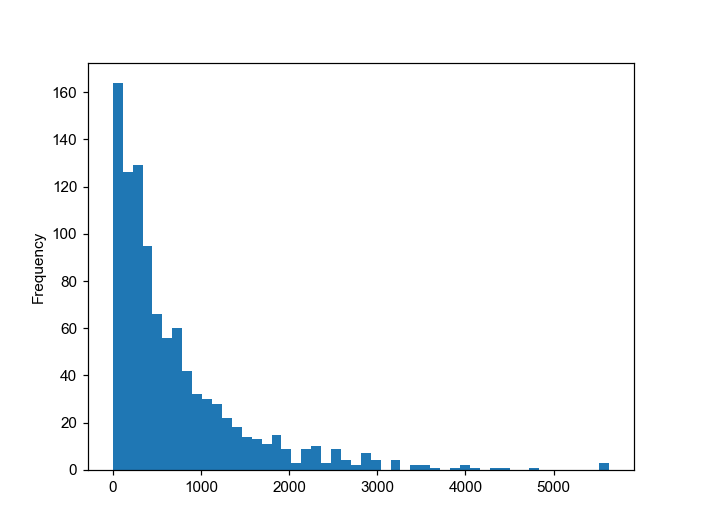

f_0       f_1       f_2       f_3       f_4       f_5       f_6  \
0  0.782984  0.405777  1.271344  0.441328  6.213987  3.309173  1.243106   
1  2.200290  1.073383  2.345141  3.815597  0.793252  0.695872  0.225893   
2  0.895954  0.254698  0.268411  0.426313  3.646376  3.430244  0.487555   
3  0.965571  1.846242  0.617436  0.952267  0.090646  1.833966  1.244527   
4  0.902840  1.368750  0.195785  8.409544  0.947753  0.429911  1.281038   

        f_7       f_8       f_9           mu  counts  
0  2.329416  6.219774  0.174162  1207.644561    4128  
1  1.123338  1.349674  1.735488   594.983356     393  
2  0.851777  0.358008  3.668615   785.765588      95  
3  3.195885  2.060368  1.340935   738.600384     197  
4  0.548729  0.391925  0.585939   528.657052     772

In [71]:
# define expected number of mutations at random for 1000 samples
df = pd.DataFrame({})
for i in range(10):
    df['f_{}'.format(i)] = np.exp(np.random.normal(size=1000))
weights = 10 * np.array(range(10))
df['mu'] = df.apply(lambda row: np.dot(row, weights), axis=1)
df['counts'] = df['mu'].map(lambda x: nbinom_rvs(x, a))
df['counts'].plot.hist(bins=50)
plt.show()
df.head()

In [72]:
model = Regressor(**params)
x_data = df[['f_{}'.format(i) for i in range(10)]]
y_data = df['counts']
model.train(x_data, y_data)

In [73]:
shap.initjs() 

# train XGBoost model
# model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(x_data, label=y_data), 100)

# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
shap_values = shap.TreeExplainer(model.model).shap_values(x_data)

In [74]:
# visualize the additive explanation of the response prediction per sample
shap.force_plot(shap_values, x_data)

<IPython.core.display.Javascript object>


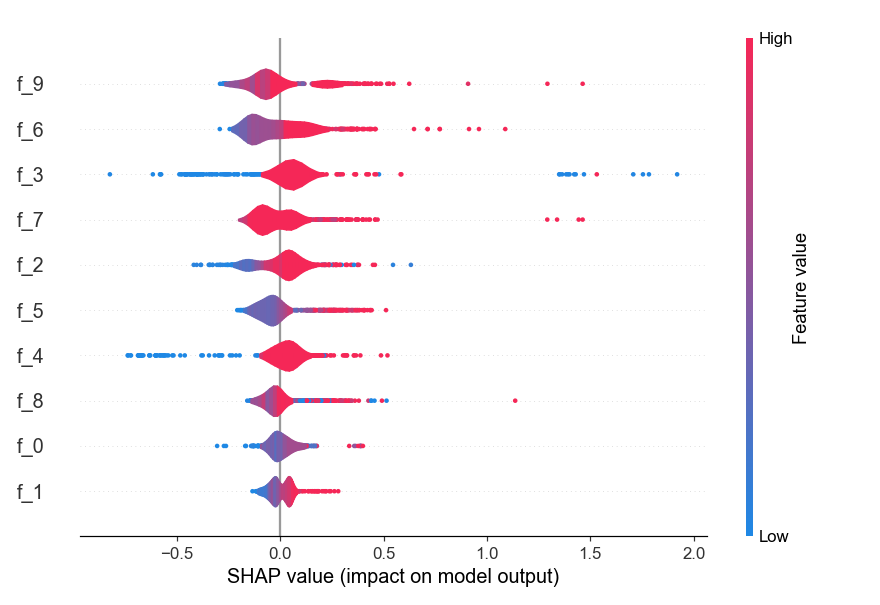

In [75]:
feature_order, feature_names, features, shap_values = shap.summary_plot(shap_values, x_data, 
                                                                        plot_type="violin", 
                                                                        max_display=25)

In [52]:
feature_order, feature_names, features, shap_values = shap.summary_plot(shap_values, x_data, 
                                                                        plot_type="bar", 
                                                                        max_display=25)

In [53]:
feature_order[::-1]

array([4, 0, 2, 5, 7, 1, 6, 9, 3, 8])

In [54]:
argsort = np.argsort(np.median(np.abs(shap_values), axis=0)[:-1])

In [55]:
argsort[::-1]

array([4, 0, 2, 5, 7, 6, 1, 9, 8, 3])

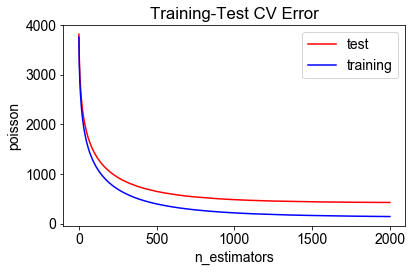

In [638]:
CV = model.cv(fold=2, method='poisson-nloglik')
fig, ax = plt.subplots()
CV.plot(ax)
plt.show()

## TODO:

- Measure overdispersion from raw data
- Estimate mean from raw data
- Build synthetic data model
- Permutation distance score for feature ranking
- Grid search for low error rate and low permutation distance
- Possibility that some response count distributions are mixtures

In [ ]:
import xgboost as xgb

params= {'booster': 'dart',
         'max_depth': 5, 
         'learning_rate': 0.1,
         'objective': 'binary:logistic', 
         'silent': True,
         'sample_type': 'uniform',
         'normalize_type': 'tree',
         'rate_drop': 0.1,
         'skip_drop': 0.5}


#read in data
dtrain = xgb.DMatrix('/home/fmuinos/anaconda3/envs/xgboost/')
dtest = xgb.DMatrix('demo/data/agaricus.txt.test')
# specify parameters via map
num_round = 2
bst = xgb.train(param, dtrain, num_round)
# make prediction
preds = bst.predict(dtest)
